In [18]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import torch.utils.data as Data
import matplotlib.pyplot as plt

In [3]:
train_data_path = r"C:\Users\DZL102\Desktop\kaggle\kaggle_house_pred_train.csv"
train_data = pd.read_csv(train_data_path, sep=",", header=0)
test_data_path = r"C:\Users\DZL102\Desktop\kaggle\kaggle_house_pred_test.csv"
test_data = pd.read_csv(test_data_path, sep=",", header=0)

In [9]:
# print(train_data.head(5))
# print(train_data.shape)
all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))  # 竖向拼接

numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
all_features[numeric_features] = all_features[numeric_features].apply(
    lambda x: (x - x.mean()) / (x.std()))
# print(all_features)
# 标准化后，每个数值特征的均值变为0，所以可以直接用0来替换缺失值
all_features[numeric_features] = all_features[numeric_features].fillna(0)

all_features = pd.get_dummies(all_features, dummy_na=True)
all_features.shape

(2919, 331)

In [13]:
n_train = train_data.shape[0]
train_features = torch.tensor(all_features[:n_train].values, dtype=torch.float32)
test_features = torch.tensor(all_features[n_train:].values, dtype=torch.float32)
train_labels = torch.tensor(train_data.SalePrice.values.reshape(-1, 1), dtype=torch.float32)

fold 1, train log rmse 0.170161,valid log rmse 0.156618
fold 2, train log rmse 0.161831,valid log rmse 0.189311
fold 3, train log rmse 0.163874,valid log rmse 0.168740
fold 4, train log rmse 0.168387,valid log rmse 0.155154
fold 5, train log rmse 0.162836,valid log rmse 0.182778


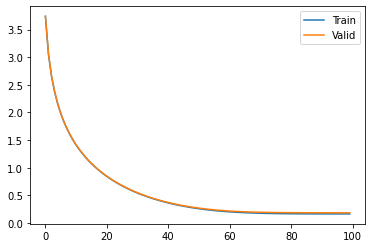

5-折验证，平均训练log rmse: 0.165418，平均验证log rmse: 0.170520


In [36]:
# 训练
class LinearReg(nn.Module):
    def __init__(self, in_features):
        super(LinearReg, self).__init__()
        self.linear = nn.Linear(in_features, 1)
        
    def forward(self, x):
        return self.linear(x)
    

loss = nn.MSELoss()


def LogRmse(model, features, labels):
    with torch.no_grad():
        clipped_preds = torch.max(model(features), torch.tensor(1.0))
        rmse = torch.sqrt(loss(torch.log(clipped_preds), torch.log(labels)))

    return rmse.item()


def train(model, train_features, train_labels, test_features, test_labels,
         num_epochs, learning_rate, weight_decay, batch_size):
    train_loss, test_loss = [], []
    
    train_dataset = Data.TensorDataset(train_features, train_labels)
    train_loader = Data.DataLoader(train_dataset, batch_size, shuffle=True)
    
    optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    for epoch in range(num_epochs):
        for X, y in train_loader:
            optimizer.zero_grad()
            out = model(X)
            l = loss(out, y)
            l.backward()
            optimizer.step()
        train_loss.append(LogRmse(model, train_features, train_labels))
        if test_labels is not None:
            test_loss.append(LogRmse(model, test_features, test_labels))

    return train_loss, test_loss
        
    
def Get_K_Fold_Data(k, i, X, y):
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = torch.cat([X_train, X_part], 0)
            y_train = torch.cat([y_train, y_part], 0)
    return X_train, y_train, X_valid, y_valid


def K_fold(k, X_train, y_train, num_epochs,
           learning_rate, weight_decay, batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = Get_K_Fold_Data(k, i, X_train, y_train)
        model = LinearReg(X_train.shape[1])
        train_ls, valid_ls = train(model, *data, num_epochs, learning_rate, weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        
        print(f'fold {i + 1}, train log rmse {float(train_ls[-1]):f},'
             f'valid log rmse {float(valid_ls[-1]):f}')
        if i == k - 1:
            x = [i for i in range(len(train_ls))]
            plt.plot(x, train_ls, label="Train")
            plt.plot(x, valid_ls, label="Valid")
            plt.legend()
            plt.show()
    
    return train_l_sum / k, valid_l_sum / k


k, num_epochs, lr, weight_decay, batch_size = 5, 100, 5, 0, 64
train_l, valid_l = K_fold(k, train_features, train_labels, num_epochs, lr, weight_decay, batch_size)
print("%d-折验证，平均训练log rmse: %f，平均验证log rmse: %f" % (k, train_l, valid_l))